Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


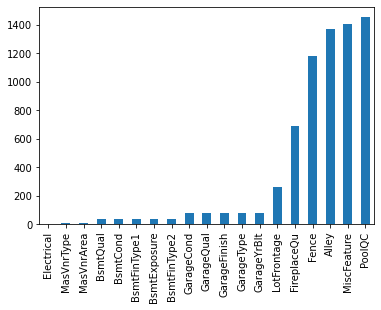

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import csv


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20


# reading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.drop(columns=['Id'])
test = test.drop(columns=['Id'])


# quantitative and qualitative features
quantitative = [i for i in train.columns if train.dtypes[i] != 'object']
quantitative.remove('SalePrice')

qualitative = [i for i in train.columns if train.dtypes[i] == 'object']

all = quantitative+qualitative
with open('AllFeatures.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(all)

# checking missing values
missing = train.isnull().sum()
bar_missing = missing[missing>0].sort_values()
print(bar_missing)
bar_missing.plot.bar()

In [2]:
# removing feature with more than 15% missing values
train = train.drop(columns=['LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'])

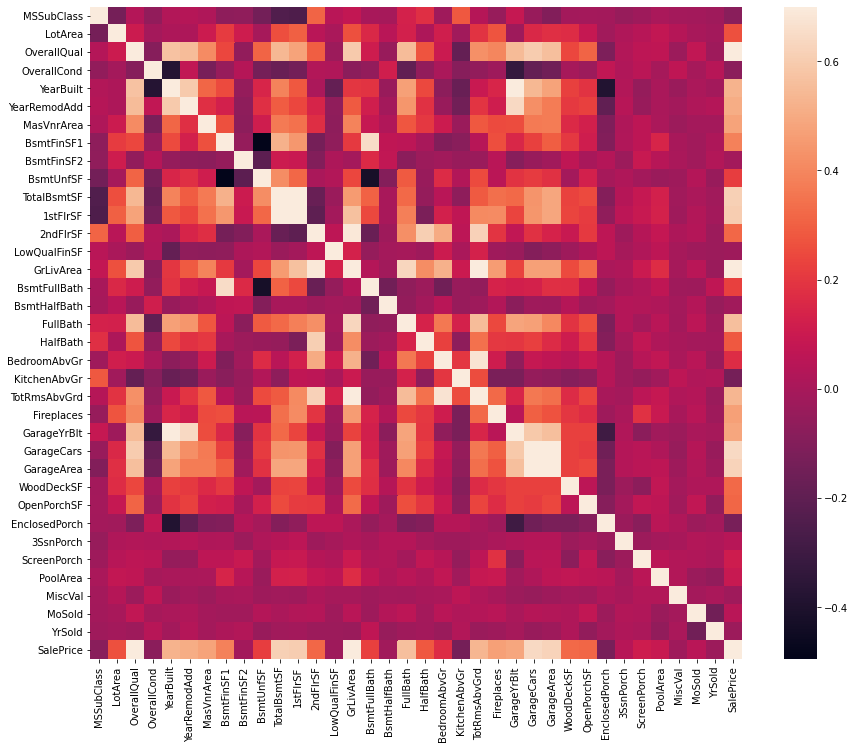

In [3]:
corrTrain = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corrTrain,vmax=.7, square=True)
#corrTrain

In [4]:
# This part of code is inspired by the discussion in
# https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5

# Based on the correlation matrix, we create polynomial features with degrees 2 and 3 for the following features.
# These features have a high correlation with the sale price.
# Note we did not consider time-based features.
# 'OverallQual', 'MasVnrArea', 'BsmtFinSF1'
# 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',  'FullBath', 'TotRmsAbvGrd'
# 'Fireplaces', GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'

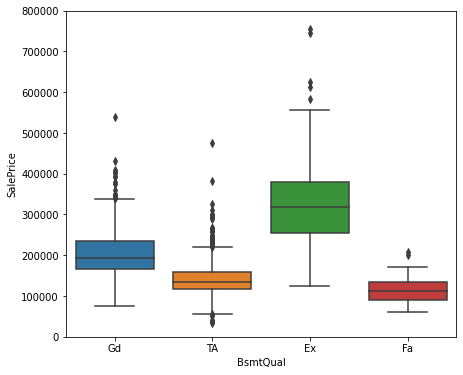

In [5]:
# let's look at each feature more carefully.
# F1
var = 'BsmtQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
plt.subplots(figsize=(7, 6))
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)
fig.axis(ymin=0, ymax=800000);

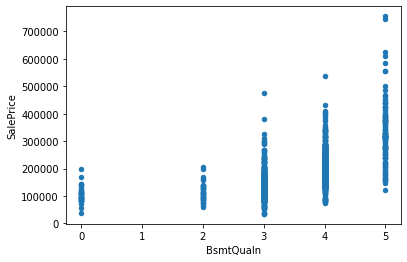

In [6]:
# We add one class for which it shows there is no Bsmt.
train.loc[train.TotalBsmtSF == 0, 'BsmtQual'] = "No"
scale_mapper = {'No': 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

# This is actually the ordinary categorical feature.
# Let's map it to scalar values 
train['BsmtQualn'] = train['BsmtQual'].replace(scale_mapper)
var = 'BsmtQualn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

# let's do the same for all ordinal categorical features.

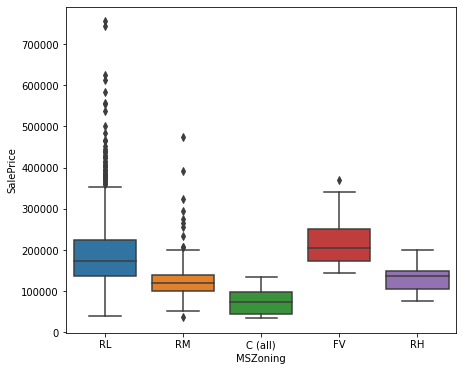

In [7]:
# F2
var = 'MSZoning'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
plt.subplots(figsize=(7, 6))
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)

# dummy variable

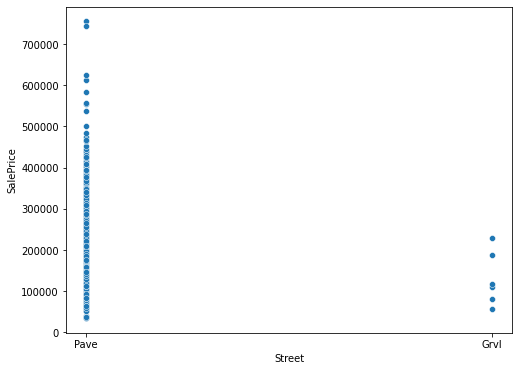

In [8]:
# F3
var = 'Street'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x= var, y='SalePrice', data = dataPlot)

# We drop this feature since one label has very few samples.
train = train.drop(columns=['Street'])

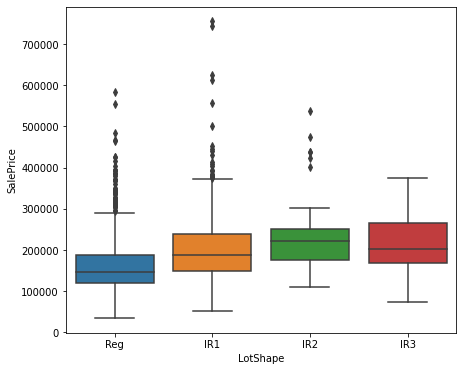

In [9]:
# F4
var = 'LotShape'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
plt.subplots(figsize=(7, 6))
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

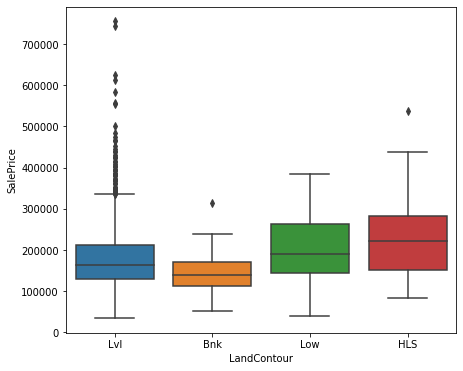

In [10]:
# F5
var = 'LandContour'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
plt.subplots(figsize=(7, 6))
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

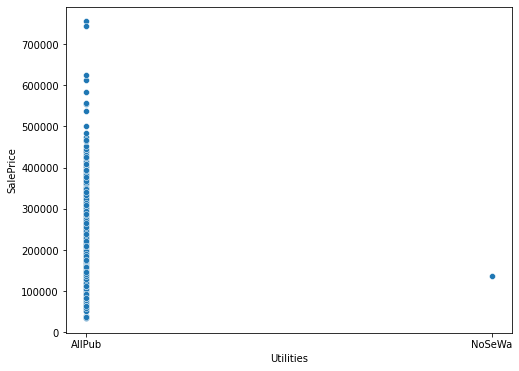

In [11]:
# F6
var = 'Utilities'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x= var, y='SalePrice', data = dataPlot)
# We drop this feature since one label has very few samples.
train = train.drop(columns=['Utilities'])

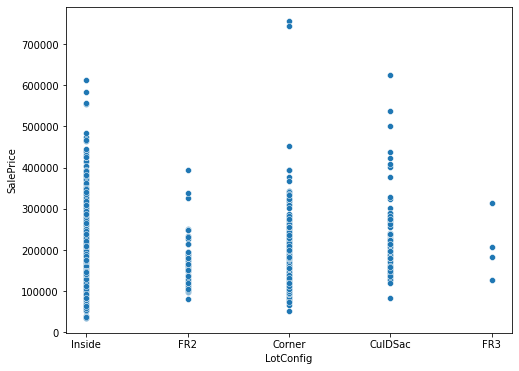

In [12]:
# F7
var = 'LotConfig'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.scatterplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

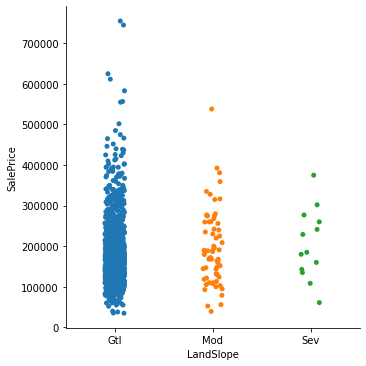

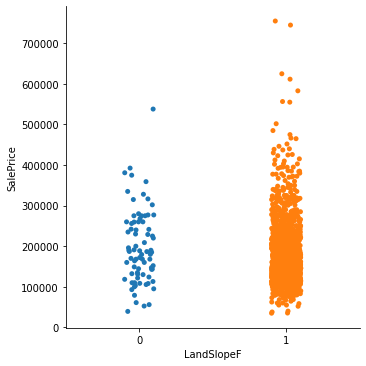

In [13]:
# F8
var = 'LandSlope'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# We create a 0/1 feature for this one.
train['LandSlopeF'] = train['LandSlope'].map(lambda x:1 if x=='Gtl' else 0)
var = 'LandSlopeF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)


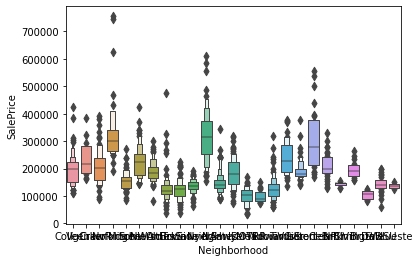

In [14]:
# F9
var = 'Neighborhood'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.boxenplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

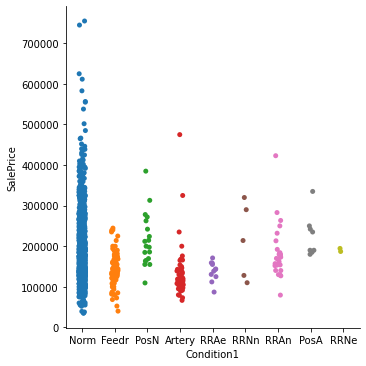

In [15]:
# F9
var = 'Condition1'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

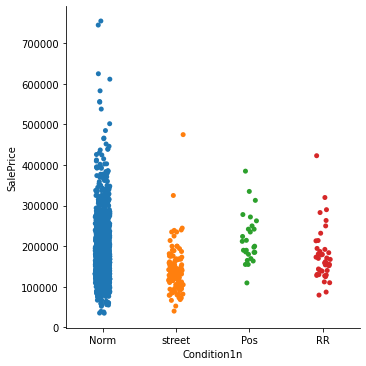

In [16]:
# let's see! based on descripton we create a new feature.
# Norm, Feedr+Artey, RRNn+RRAn+RRNe+RRAe, PosN+PosA: four categorical labels
scale_mapper = {'Artery':'street', 'Feedr':'street', 'Norm':'Norm',
                'RRNn':'RR', 'RRAn':'RR', 'RRNe':'RR', 'RRAe':'RR',
                'PosN':'Pos','PosA':'Pos'}
train['Condition1n'] = train['Condition1'].replace(scale_mapper)
var = 'Condition1n'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

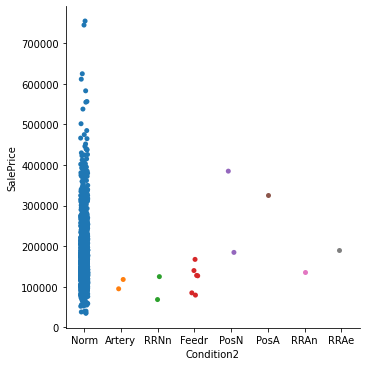

In [17]:
# F10
var = 'Condition2'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

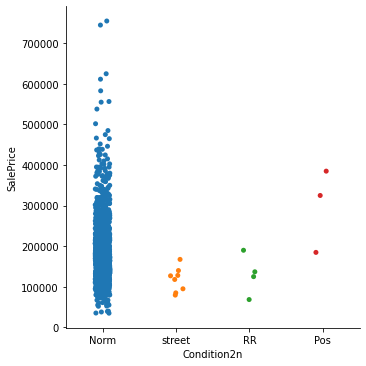

In [18]:
# We do what we did for 'Condition1' feature
scale_mapper = {'Artery':'street', 'Feedr':'street', 'Norm':'Norm',
                'RRNn':'RR', 'RRAn':'RR', 'RRNe':'RR', 'RRAe':'RR',
                'PosN':'Pos','PosA':'Pos'}
train['Condition2n'] = train['Condition2'].replace(scale_mapper)
var = 'Condition2n'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

In [19]:
# let's see whether the condition2 is different from condition1 (flag)
train.loc[train.Condition1n == train.Condition2n, 'Condition2nf'] = 0
train.loc[train.Condition1n != train.Condition2n, 'Condition2nf'] = 1

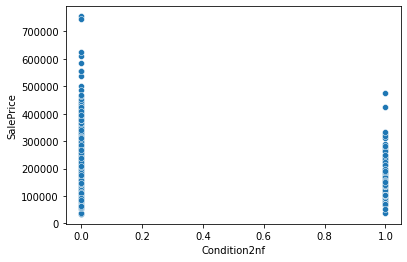

In [20]:
var = 'Condition2nf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.scatterplot(x= var, y='SalePrice', data = dataPlot)

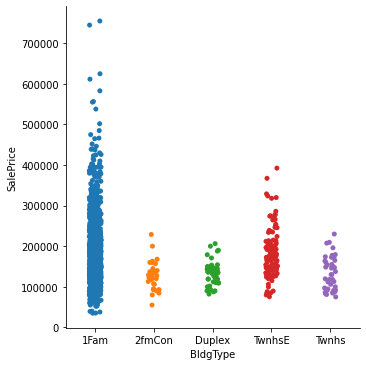

In [21]:
# F11
var = 'BldgType'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

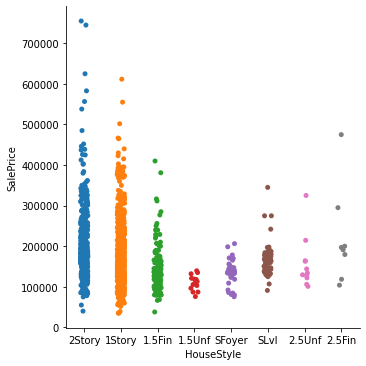

In [22]:
# F12
var = 'HouseStyle'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

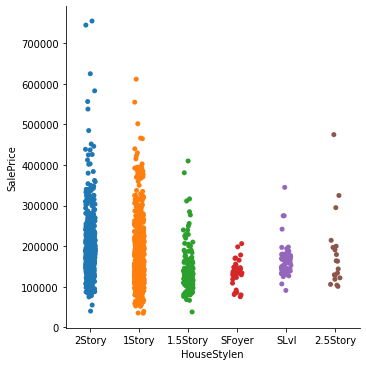

In [23]:
# let's see! based on the description, we cluster this feature into 6 classes
scale_mapper = {'1.5Fin':'1.5Story', '1.5Unf':'1.5Story',
                '2.5Fin':'2.5Story', '2.5Unf':'2.5Story',
                '1Story':'1Story',
                '2Story':'2Story',
                'SFoyer':'SFoyer',
                'SLvl':'SLvl'}
train['HouseStylen'] = train['HouseStyle'].replace(scale_mapper)
var = 'HouseStylen'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

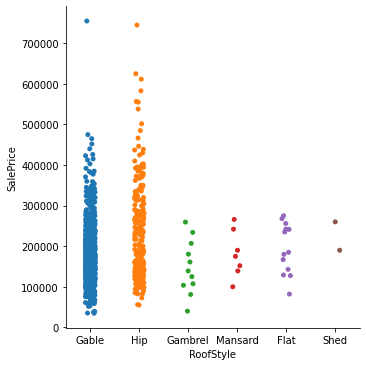

In [24]:
# F13
var = 'RoofStyle'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

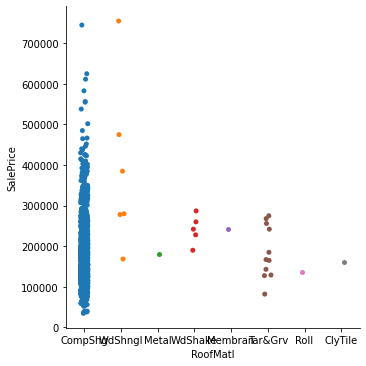

In [25]:
# F14
var = 'RoofMatl'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable (note we apply feature reduction at the end of data preparation)

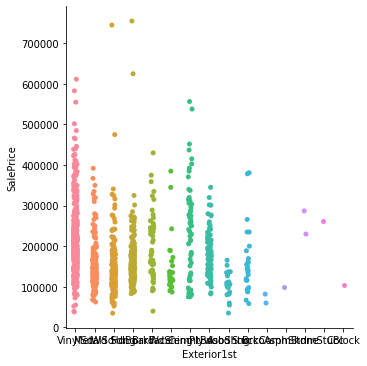

In [26]:
# F15
var = 'Exterior1st'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable 

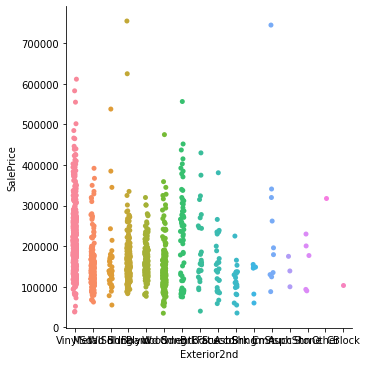

In [27]:
# F16
var = 'Exterior2nd'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

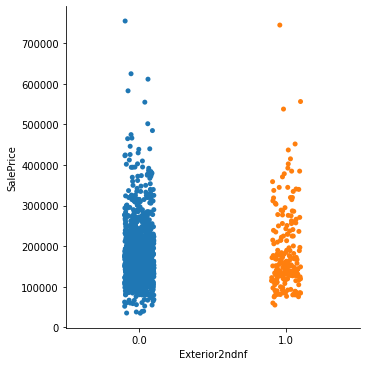

In [28]:
# let's see whether the 'Exterior2nd' is different from 'Exterior1st' (flag)
train.loc[train.Exterior1st == train.Exterior2nd, 'Exterior2ndnf'] = 0
train.loc[train.Exterior1st != train.Exterior2nd, 'Exterior2ndnf'] = 1
var = 'Exterior2ndnf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

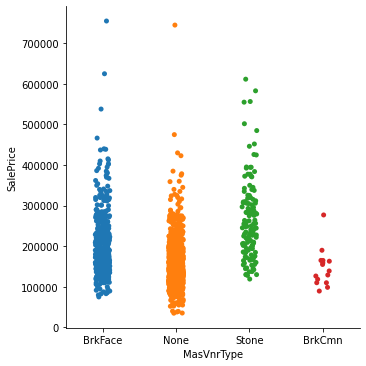

In [29]:
# F17
var = 'MasVnrType'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable 

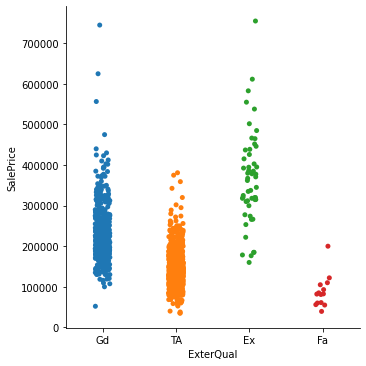

In [30]:
# F18
var = 'ExterQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

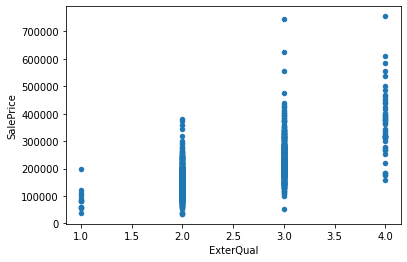

In [31]:
# Ordinal data
scale_mapper = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
train['ExterQual'] = train['ExterQual'].replace(scale_mapper)
var = 'ExterQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

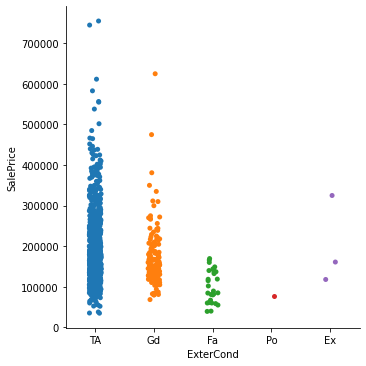

In [32]:
# F19
var = 'ExterCond'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# Based on the figure, this feature is not ordinal data
# but, let's cluster some of the classes

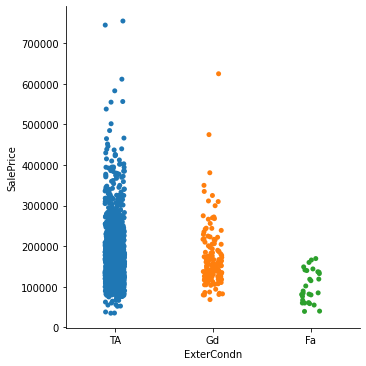

In [33]:
scale_mapper = {'TA':'TA',
                'Gd':'Gd', 'Ex':'Gd',
                'Fa':'Fa', 'Po':'Fa' }
train['ExterCondn'] = train['ExterCond'].replace(scale_mapper)
var = 'ExterCondn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

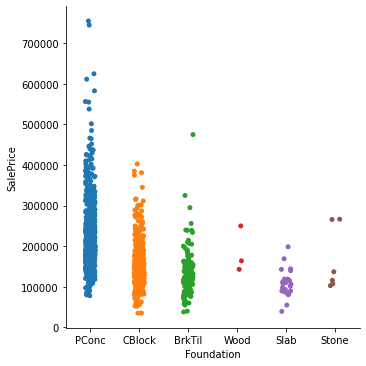

In [34]:
# F20
var = 'Foundation'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# we will not cluster stone and wood classes. Their median is far from each other.
# dummy variable 

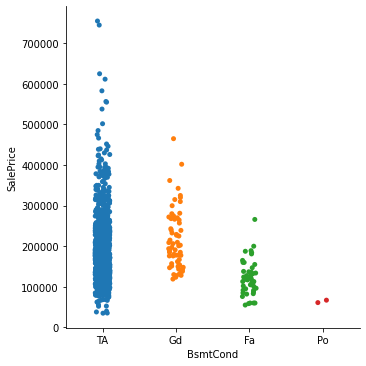

In [35]:
# F21
var = 'BsmtCond'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

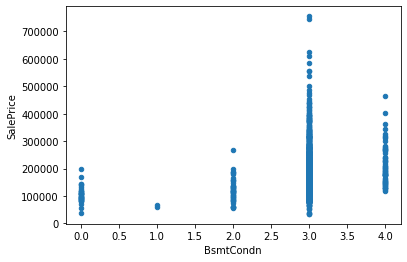

In [36]:
# We add one class for which it shows there is no Bsmt.
train.loc[train.TotalBsmtSF == 0, 'BsmtCond'] = "No"
scale_mapper = {'No': 0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
# ordinal data
train['BsmtCondn'] = train['BsmtCond'].replace(scale_mapper)
var = 'BsmtCondn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

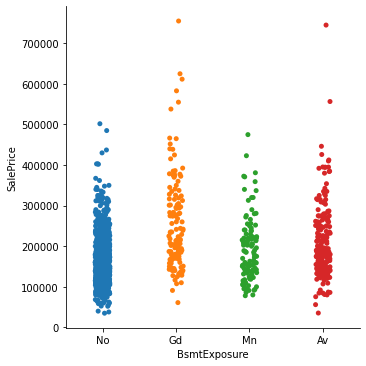

In [37]:
# F22
var = 'BsmtExposure'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

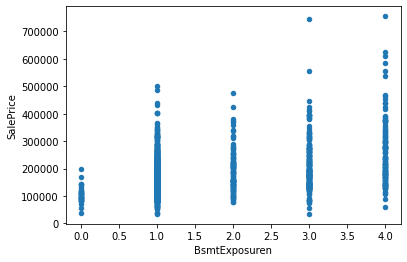

In [38]:
# We add one class for which it shows there is no Bsmt.
train.loc[train.TotalBsmtSF == 0, 'BsmtExposure'] = "NoB"
scale_mapper = {'NoB':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4, 'Ex':5}
# ordinal data
train['BsmtExposuren'] = train['BsmtExposure'].replace(scale_mapper)
var = 'BsmtExposuren'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

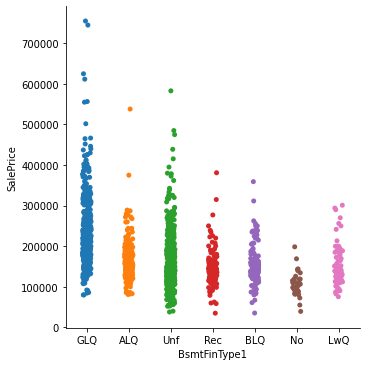

In [39]:
# F23
# We add one class for which it shows there is no Bsmt.
train.loc[train.TotalBsmtSF == 0, 'BsmtFinType1'] = "No"
var = 'BsmtFinType1'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable 

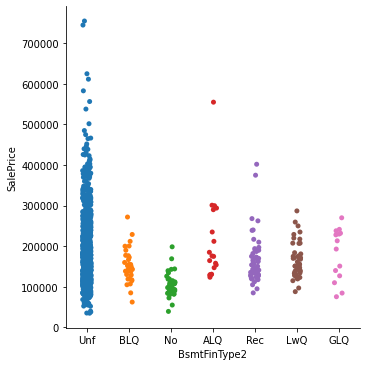

In [40]:
# F24
# We add one class for which it shows there is no Bsmt.
train.loc[train.TotalBsmtSF == 0, 'BsmtFinType2'] = "No"
var = 'BsmtFinType2'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# we don't compare 'BsmtFinType2' and 'BsmtFinType1' to see whether they are different or not.
# Because the two figures vary too much 
# dummy variable 

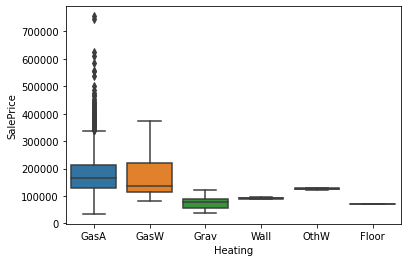

In [41]:
# F25
var ='Heating'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)

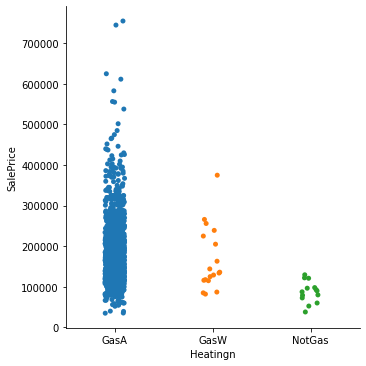

In [42]:
# let's cluster some of the classes.
scale_mapper = {'GasA':'GasA',
                'GasW': 'GasW',
                'Grav': 'NotGas', 'Wall': 'NotGas', 'OthW': 'NotGas', 'Floor': 'NotGas'}

train['Heatingn']= train['Heating'].replace(scale_mapper)
var = 'Heatingn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable 

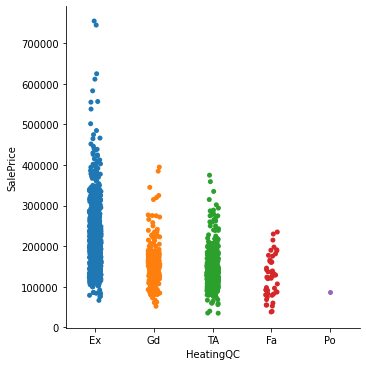

In [43]:
# F26
var =  'HeatingQC'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

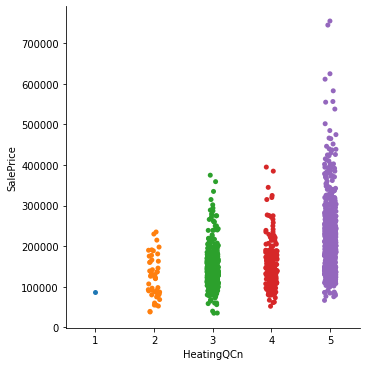

In [44]:
# ordinal data
scale_mapper = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train['HeatingQCn'] = train['HeatingQC'].replace(scale_mapper)
var =  'HeatingQCn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

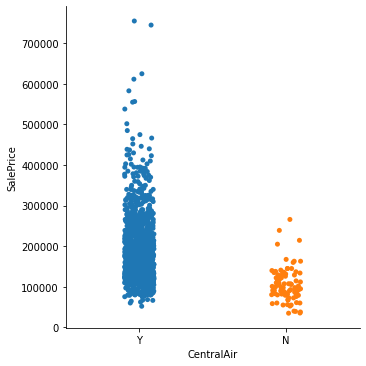

In [45]:
# F27
var = 'CentralAir'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)


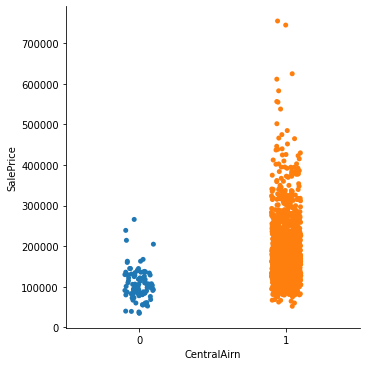

In [46]:
# 0/1 
train['CentralAirn'] = train['CentralAir'].map(lambda x: 1 if x=='Y' else 0)
var = 'CentralAirn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

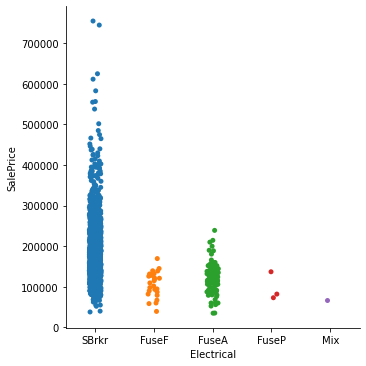

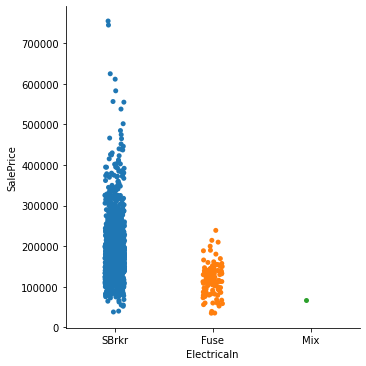

In [47]:
# F28
var = 'Electrical'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# Cluster some classes based on the description
scale_mapper = {'SBrkr':'SBrkr',
                'Mix': 'Mix',
                'FuseF': 'Fuse', 'FuseA': 'Fuse', 'FuseP': 'Fuse'}
train['Electricaln'] = train['Electrical'].replace(scale_mapper)
var = 'Electricaln'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

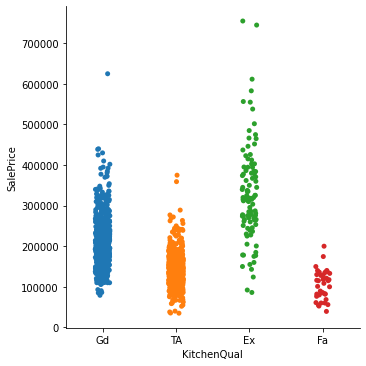

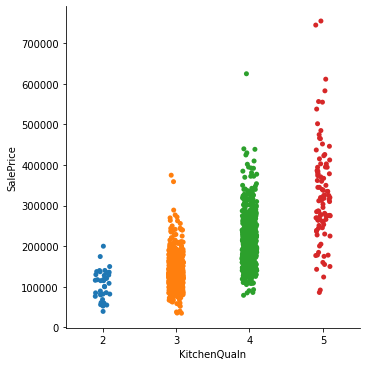

In [48]:
# F29
var = 'KitchenQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# ordinal data
scale_mapper = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
train['KitchenQualn'] = train['KitchenQual'].replace(scale_mapper)
var = 'KitchenQualn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

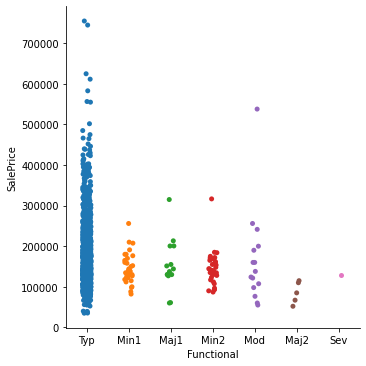

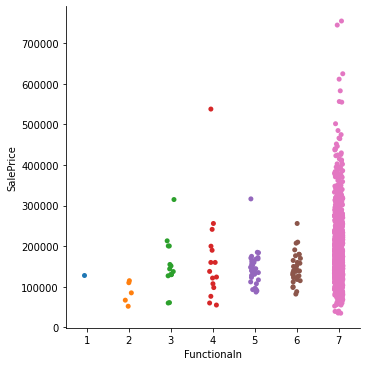

In [49]:
# F30
var = 'Functional'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# ordinal data
scale_mapper = {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3,
                'Maj2':2, 'Sev':1}
train['Functionaln'] = train['Functional'].replace(scale_mapper)
var = 'Functionaln'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

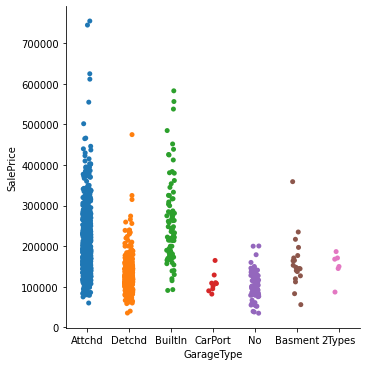

In [50]:
# F31
# We add one class for which it shows there is no garage.
train.loc[train.GarageArea == 0, 'GarageType'] = "No"
var = 'GarageType'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# I think it has order, but let's just dummy

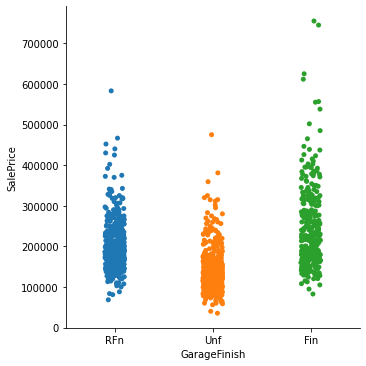

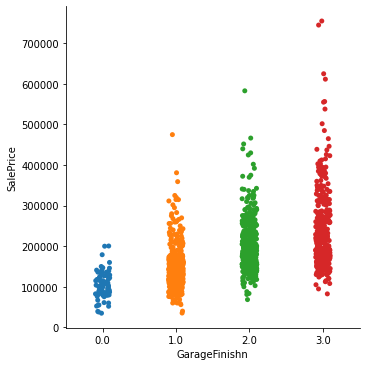

In [51]:
# F32
var = 'GarageFinish'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# ordinal data
scale_mapper = {'Fin':3, 'RFn':2, 'Unf':1}
train['GarageFinishn'] = train['GarageFinish'].replace(scale_mapper)
train.loc[train.GarageArea == 0, 'GarageFinishn'] = 0

var = 'GarageFinishn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

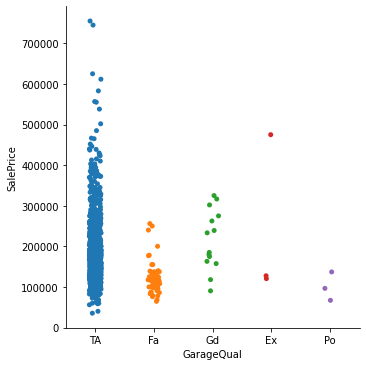

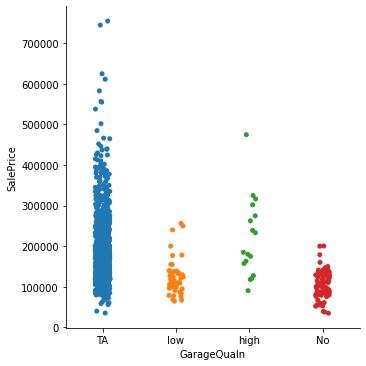

In [52]:
# F33
var = 'GarageQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# Cluster some classes
scale_mapper = {'TA':'TA',
                'Ex':'high', 'Gd': 'high',
                'Fa':'low', 'Po':'low'}
train['GarageQualn'] = train['GarageQual'].replace(scale_mapper)
# We add one class for which it shows there is no garage.
train.loc[train.GarageArea == 0, 'GarageQualn'] = 'No'

var = 'GarageQualn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

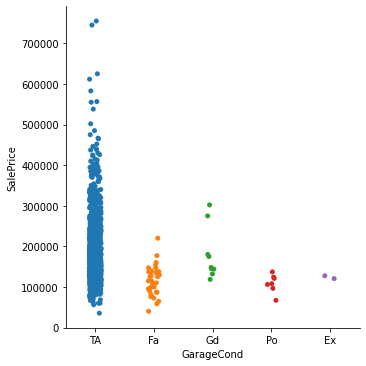

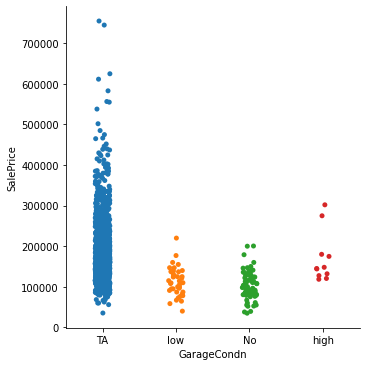

In [53]:
# F34
var = 'GarageCond'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# cluster some classes
scale_mapper = {'TA':'TA',
                'Ex':'high', 'Gd': 'high',
                'Fa':'low', 'Po':'low'}
train['GarageCondn'] = train['GarageCond'].replace(scale_mapper)
# We add one class for which it shows there is no garage.
train.loc[train.GarageArea == 0, 'GarageCondn'] = 'No'

var = 'GarageCondn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

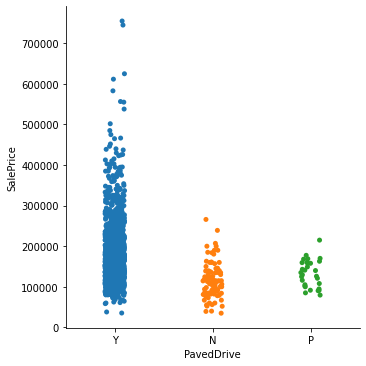

In [54]:
# F35
var = 'PavedDrive'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

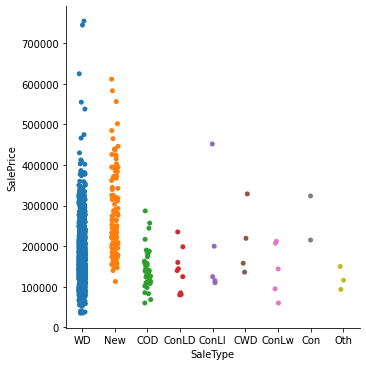

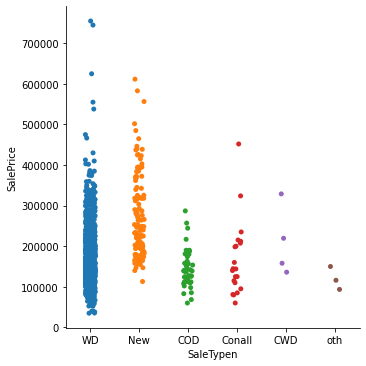

In [55]:
# F36
var = 'SaleType'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# cluster some classes
scale_mapper = {'WD':'WD',
                'New':'New', 
                'COD':'COD',
                'CWD': 'CWD',
                'Oth': 'oth',
                'ConLD':'Conall' , 'ConLI':'Conall' ,'ConLw':'Conall', 'Con':'Conall'}
train['SaleTypen'] = train['SaleType'].replace(scale_mapper)
var = 'SaleTypen'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

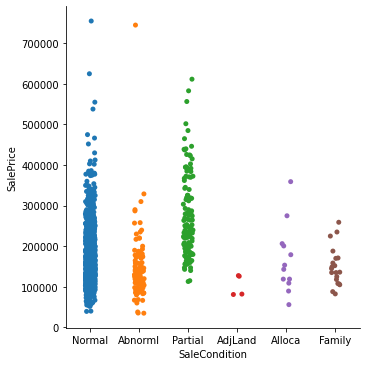

In [56]:
# F37
var = 'SaleCondition'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# dummy variable

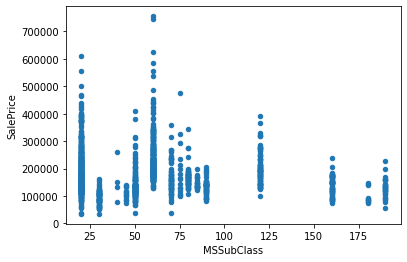

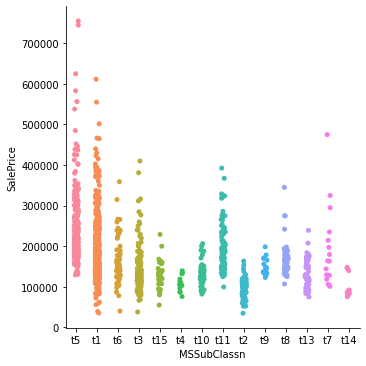

In [57]:
# numerical features
# F38
var = 'MSSubClass'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# it shows that this feature is actually categorical data rather than numerical data. 
# categorcial data 
scale_mapper = {20:'t1',
                30:'t2',
                40:'t3', 50:'t3', 
                45:'t4',
                60: 't5',
                70: 't6',
                75:'t7' ,
                80:'t8',
                85: 't9',
                90:'t10',
                120: 't11',
                150: 't12',
                160: 't13',
                180: 't14',
                190: 't15'
                }
train['MSSubClassn'] = train['MSSubClass'].replace(scale_mapper)

var = 'MSSubClassn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

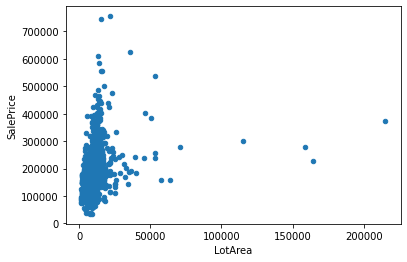

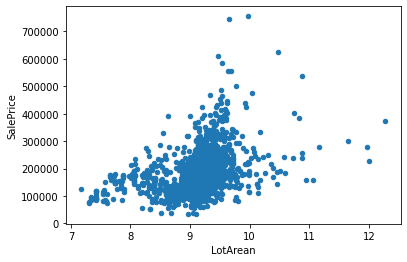

In [58]:
# F39
var = 'LotArea'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# positive skewness, log transformation
train['LotArean'] = train['LotArea'].map(lambda x:np.log(x))
var = 'LotArean'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')


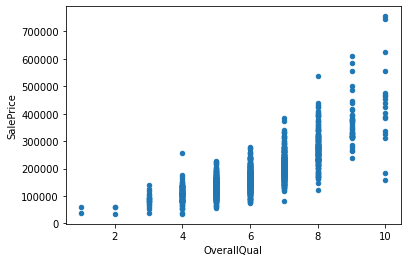

In [59]:
# F40
var = 'OverallQual'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = dataPlot.plot.scatter(x= var, y='SalePrice')
# great relation with price

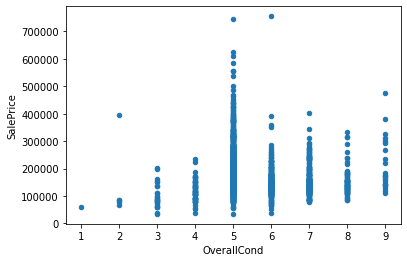

In [60]:
# F41
var = 'OverallCond'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

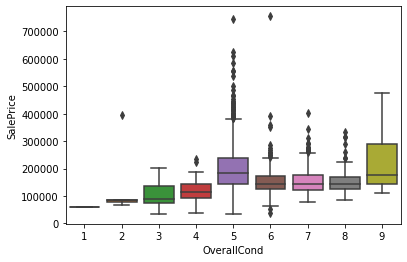

In [61]:
var = 'OverallCond'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)
# It is somehow ordinal data. let's keep it as it is (we do not create the categorical feature)
# I mean, we can see that price increases with the values of the feature, so we do not need to create a categorical
# feature. For example, we did create a categorical feature for MSSubClassn, since
# there was no relationship between price and the numerical value of the feature.

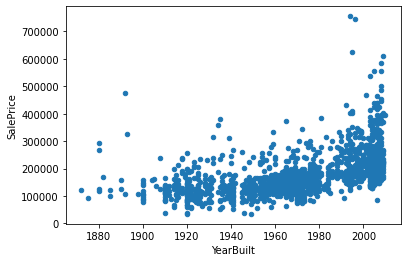

In [62]:
# F42
var = 'YearBuilt'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

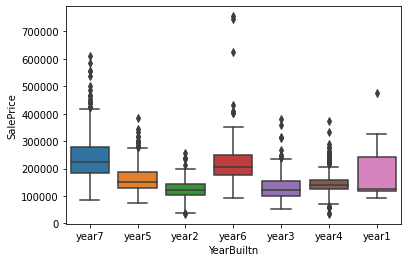

In [63]:
train['YearBuilt'].min()
# time-based feature! (sequence model? not for now!)
# we also create another categorical feature based on 'YearBuilt' feature.
# min = 1872, max =  2010
# (2010,2000), (1990, 2000), (1990-1872)/5 = 24
train['YearBuiltn'] = 'year1'
train.loc[(train['YearBuilt'] <= 1896), 'YearBuiltn'] = 'year1'
train.loc[(train['YearBuilt'] > 1896) & (train['YearBuilt'] <= 1920), 'YearBuiltn'] = 'year2'
train.loc[(train['YearBuilt'] > 1920) & (train['YearBuilt'] <= 1944), 'YearBuiltn'] = 'year3'
train.loc[(train['YearBuilt'] > 1944) & (train['YearBuilt'] <= 1968), 'YearBuiltn'] = 'year4'
train.loc[(train['YearBuilt'] > 1968) & (train['YearBuilt'] <= 1990), 'YearBuiltn'] = 'year5'
train.loc[(train['YearBuilt'] > 1990) & (train['YearBuilt'] <= 2000), 'YearBuiltn'] = 'year6'
train.loc[(train['YearBuilt'] > 2000), 'YearBuiltn'] = 'year7'

var = 'YearBuiltn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.boxplot(x= var, y='SalePrice', data = dataPlot)

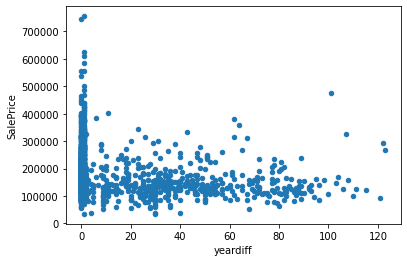

In [64]:
# F43
# based on the description, it is better to have the feature showing the 
# difference between 'YearBuilt' and 'YearRemodAdd'. Then, we remove 'YearRemodAdd' feature
train['yeardiff'] = train['YearRemodAdd']-train['YearBuilt']
dataPlot = pd.concat([train['SalePrice'], train['yeardiff']], axis = 1)
dataPlot.plot.scatter(x='yeardiff', y='SalePrice')

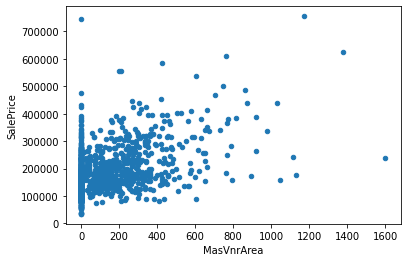

In [65]:
# F44
var = 'MasVnrArea'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# why a lot of the values for this feature are zero? Because when MasVnrType = None, then MasVnrArea = 0
# so, they have a high correlation. Let's drop 'MasVnrArea'

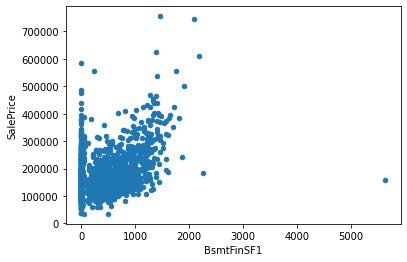

In [66]:
# F45
var =  'BsmtFinSF1'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# good?

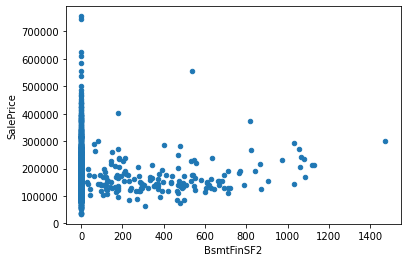

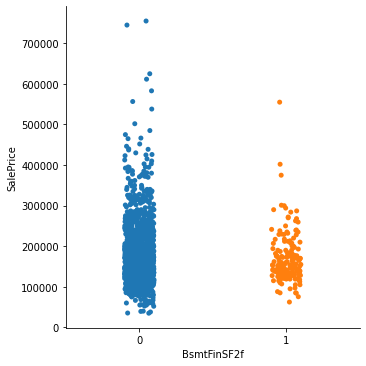

In [67]:
# F46
var = 'BsmtFinSF2'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# 0/1, since a lot of values for this feature are zero
train['BsmtFinSF2f'] = train['BsmtFinSF2'].map(lambda x:0 if x == 0 else 1)
var = 'BsmtFinSF2f'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

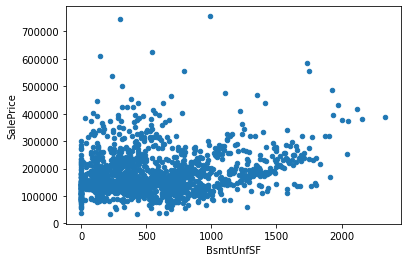

In [68]:
# F47
var = 'BsmtUnfSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# let's create a categorical feature for this one. We keep the original feature as well
train['BsmtUnfSFn'] = 'b1'
train.loc[(train['BsmtUnfSF'] <= 400), 'BsmtUnfSFn'] = 'b1'
train.loc[(train['BsmtUnfSF'] > 400) & (train['BsmtUnfSF'] <= 1000), 'BsmtUnfSFn'] = 'b2'
train.loc[(train['BsmtUnfSF'] > 1000), 'BsmtUnfSFn'] = 'b3'


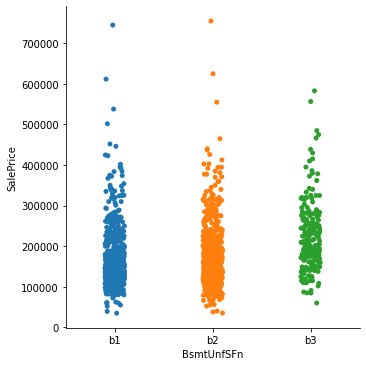

In [69]:
var = 'BsmtUnfSFn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

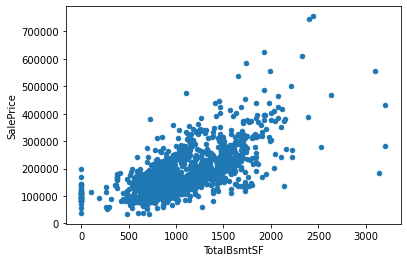

In [70]:
# F48
# Let's remove out liars!
train = train.drop(train[train['TotalBsmtSF']>5000].index)
var = 'TotalBsmtSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# let's create a categorical feature for this one. We keep the original feature as well
# Because it has a high relationship with the price

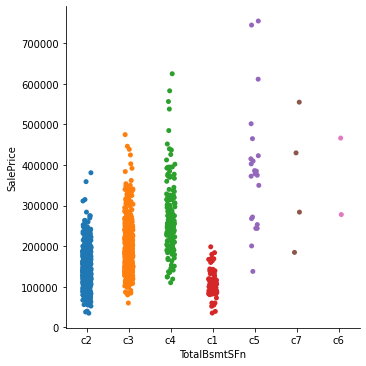

In [71]:
train['TotalBsmtSFn'] = 'c1'
train.loc[(train['TotalBsmtSF'] <= 500), 'TotalBsmtSFn'] = 'c1'
train.loc[(train['TotalBsmtSF'] > 500) & (train['BsmtUnfSF'] <= 1000), 'TotalBsmtSFn'] = 'c2'
train.loc[(train['TotalBsmtSF'] > 1000) & (train['BsmtUnfSF'] <= 1500), 'TotalBsmtSFn'] = 'c3'
train.loc[(train['TotalBsmtSF'] > 1500) & (train['BsmtUnfSF'] <= 2000), 'TotalBsmtSFn'] = 'c4'
train.loc[(train['TotalBsmtSF'] > 2000) & (train['BsmtUnfSF'] <= 2500), 'TotalBsmtSFn'] = 'c5'
train.loc[(train['TotalBsmtSF'] > 2500) & (train['BsmtUnfSF'] <= 3000), 'TotalBsmtSFn'] = 'c6'
train.loc[(train['TotalBsmtSF'] > 3000) & (train['BsmtUnfSF'] <= 4000), 'TotalBsmtSFn'] = 'c7'
train.loc[(train['TotalBsmtSF'] > 4000), 'TotalBsmtSFn'] = 'c7'
var = 'TotalBsmtSFn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

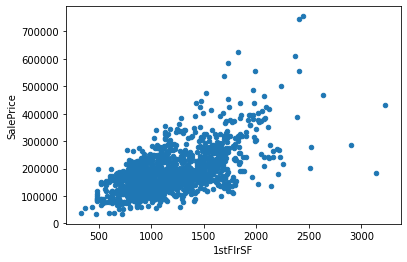

In [72]:
# F49
var = '1stFlrSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# let's create a categorical feature for this one. We keep the original feature as well
# Because it has a high relationship with the price

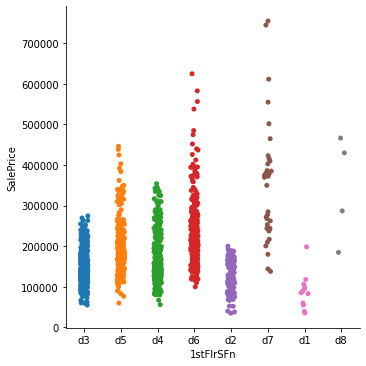

In [73]:
train['1stFlrSFn'] = 'd1'
train.loc[(train['1stFlrSF'] <= 500), '1stFlrSFn'] = 'd1'
train.loc[(train['1stFlrSF'] > 500) & (train['1stFlrSF'] <= 750), '1stFlrSFn'] = 'd2'
train.loc[(train['1stFlrSF'] > 750) & (train['1stFlrSF'] <= 1000), '1stFlrSFn'] = 'd3'
train.loc[(train['1stFlrSF'] > 1000) & (train['1stFlrSF'] <= 1250), '1stFlrSFn'] = 'd4'
train.loc[(train['1stFlrSF'] > 1250) & (train['1stFlrSF'] <= 1500), '1stFlrSFn'] = 'd5'
train.loc[(train['1stFlrSF'] > 1500) & (train['1stFlrSF'] <= 2000), '1stFlrSFn'] = 'd6'
train.loc[(train['1stFlrSF'] > 2000) & (train['1stFlrSF'] <= 2600), '1stFlrSFn'] = 'd7'
train.loc[(train['1stFlrSF'] > 2600), '1stFlrSFn'] = 'd8'
var = '1stFlrSFn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

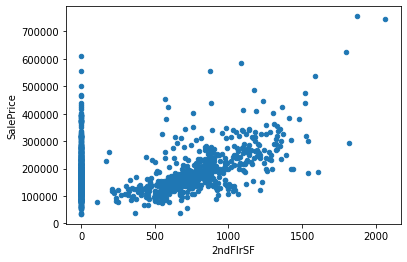

In [74]:
# F50
var = '2ndFlrSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# let's create a categorical feature for this one. We keep the original feature as well
# Because it has a high relationship with the price

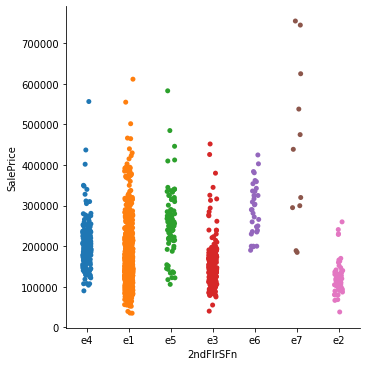

In [75]:
train['2ndFlrSFn'] = 'e1'
train.loc[(train['2ndFlrSF'] <= 100), '2ndFlrSFn'] = 'e1'
train.loc[(train['2ndFlrSF'] > 100) & (train['2ndFlrSF'] <= 500), '2ndFlrSFn'] = 'e2'
train.loc[(train['2ndFlrSF'] > 500) & (train['2ndFlrSF'] <= 750), '2ndFlrSFn'] = 'e3'
train.loc[(train['2ndFlrSF'] > 750) & (train['2ndFlrSF'] <= 1000), '2ndFlrSFn'] = 'e4'
train.loc[(train['2ndFlrSF'] > 1000) & (train['2ndFlrSF'] <= 1250), '2ndFlrSFn'] = 'e5'
train.loc[(train['2ndFlrSF'] > 1250) & (train['2ndFlrSF'] <= 1500), '2ndFlrSFn'] = 'e6'
train.loc[(train['2ndFlrSF'] > 1500), '2ndFlrSFn'] = 'e7'
var = '2ndFlrSFn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

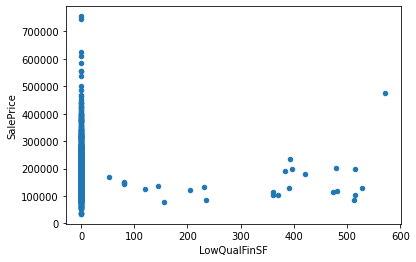

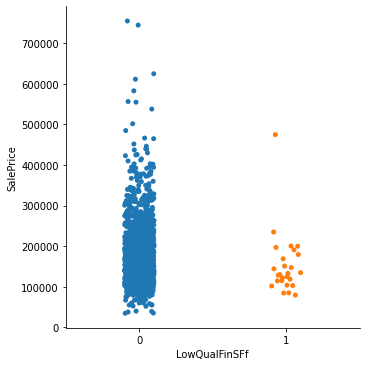

In [76]:
# F51
var = 'LowQualFinSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# 0/1, since a lot of values for this feature are zero
train['LowQualFinSFf'] = train['LowQualFinSF'].map(lambda x:0 if x == 0 else 1)
var = 'LowQualFinSFf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

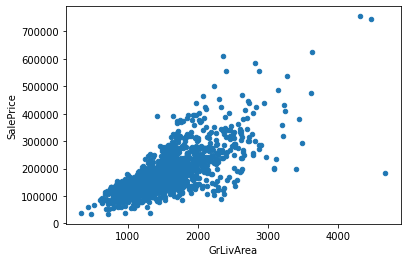

In [77]:
# F52
var = 'GrLivArea'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# let's create a categorical feature for this one. We keep the original feature as well
# Because it has a high relationship with the price

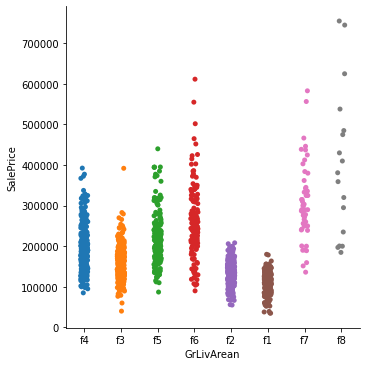

In [78]:
train['GrLivArean'] = 'f1'
train.loc[(train['GrLivArea'] <= 1000), 'GrLivArean'] = 'f1'
train.loc[(train['GrLivArea'] > 1000) & (train['GrLivArea'] <= 1250), 'GrLivArean'] = 'f2'
train.loc[(train['GrLivArea'] > 1250) & (train['GrLivArea'] <= 1500), 'GrLivArean'] = 'f3'
train.loc[(train['GrLivArea'] > 1500) & (train['GrLivArea'] <= 1750), 'GrLivArean'] = 'f4'
train.loc[(train['GrLivArea'] > 1750) & (train['GrLivArea'] <= 2000), 'GrLivArean'] = 'f5'
train.loc[(train['GrLivArea'] > 2000) & (train['GrLivArea'] <= 2500), 'GrLivArean'] = 'f6'
train.loc[(train['GrLivArea'] > 2500) & (train['GrLivArea'] <= 3000), 'GrLivArean'] = 'f7'
train.loc[(train['GrLivArea'] > 3000), 'GrLivArean'] = 'f8'
var = 'GrLivArean'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

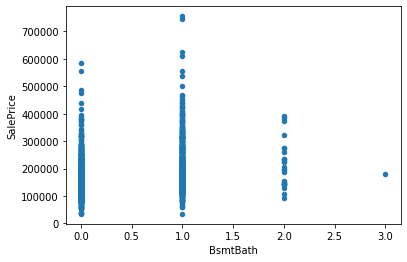

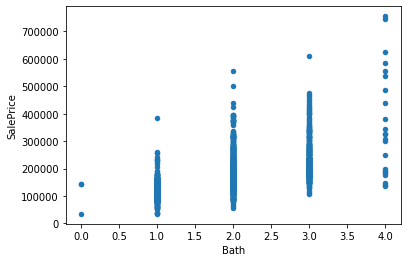

In [79]:
# F53 and F54
# bath in bsmt \ bath above bsmt
train['BsmtBath'] =  train['BsmtFullBath'] + train['BsmtHalfBath']
train['Bath'] =  train['FullBath'] + train['HalfBath']
var = 'BsmtBath'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
var = 'Bath'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

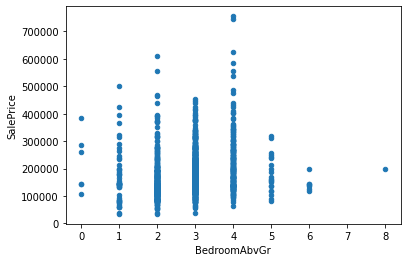

In [80]:
# F55
var = 'BedroomAbvGr'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# good

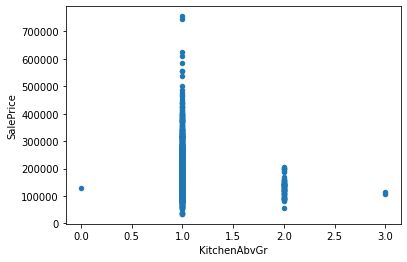

In [81]:
# F56
var = 'KitchenAbvGr'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

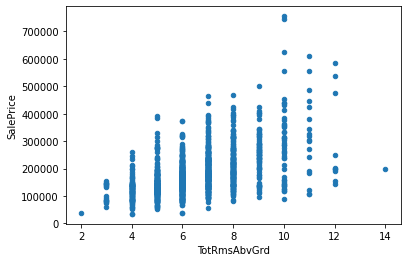

In [82]:
# F57
var =  'TotRmsAbvGrd'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# good

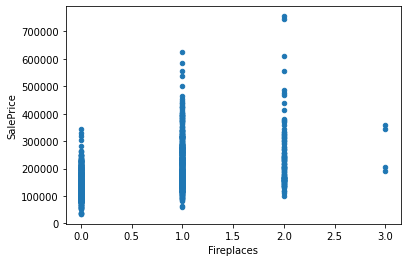

In [83]:
# F58
var = 'Fireplaces'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# good

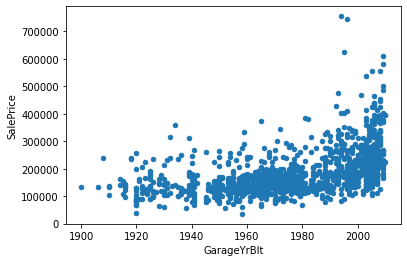

In [84]:
# F59
var =  'GarageYrBlt'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

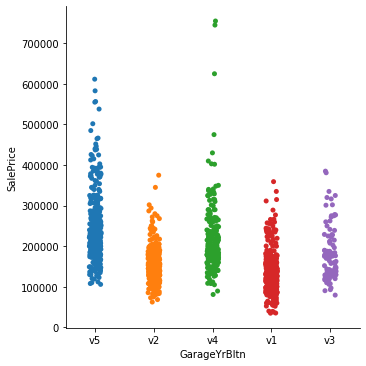

In [85]:
# time-based feature! (sequence model? not for now!)
# we also create another categorical feature based on 'GarageYrBltn' feature.
train['GarageYrBltn'] = 'v1'
train.loc[(train['GarageYrBlt'] <= 1960), 'GarageYrBltn'] = 'v1'
train.loc[(train['GarageYrBlt'] > 1960) & (train['GarageYrBlt'] <= 1980), 'GarageYrBltn'] = 'v2'
train.loc[(train['GarageYrBlt'] > 1980) & (train['GarageYrBlt'] <= 1990), 'GarageYrBltn'] = 'v3'
train.loc[(train['GarageYrBlt'] > 1990) & (train['GarageYrBlt'] <= 2000), 'GarageYrBltn'] = 'v4'
train.loc[(train['GarageYrBlt'] > 2000), 'GarageYrBltn'] = 'v5'
var = 'GarageYrBltn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

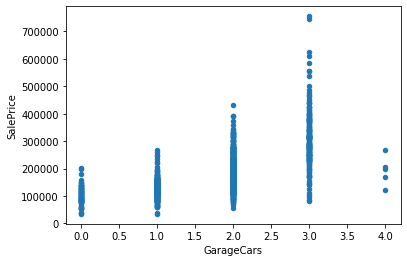

In [86]:
# F60
var =  'GarageCars'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# good 

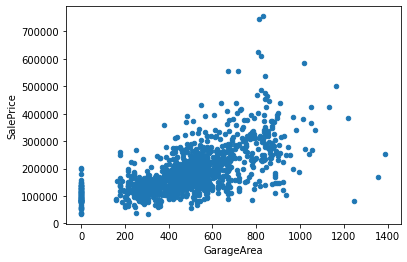

In [87]:
# F61
var =  'GarageArea'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# we can cluster some classes. But, 'GaragwCars' is the cluster of some 
# classes in 'GarageArea'. So, that is it!

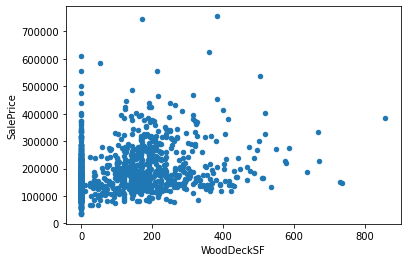

In [88]:
# F62
var = 'WoodDeckSF'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# 3 features: itself, 0/1, and categorical feature

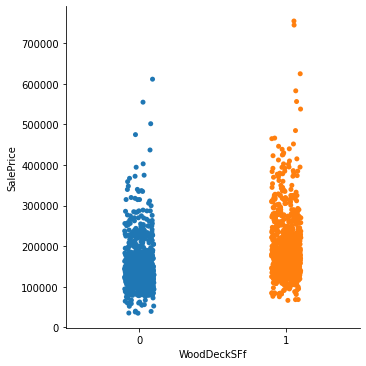

In [89]:
train['WoodDeckSFf'] = train['WoodDeckSF'].map(lambda x:0 if x == 0 else 1)
var = 'WoodDeckSFf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

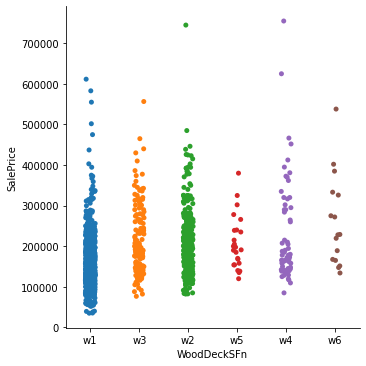

In [90]:
train['WoodDeckSFn'] = 'w1'
train.loc[(train['WoodDeckSF'] <= 100), 'WoodDeckSFn'] = 'w1'
train.loc[(train['WoodDeckSF'] > 100) & (train['WoodDeckSF'] <= 200), 'WoodDeckSFn'] = 'w2'
train.loc[(train['WoodDeckSF'] > 200) & (train['WoodDeckSF'] <= 300), 'WoodDeckSFn'] = 'w3'
train.loc[(train['WoodDeckSF'] > 300) & (train['WoodDeckSF'] <= 400), 'WoodDeckSFn'] = 'w4'
train.loc[(train['WoodDeckSF'] > 400) & (train['WoodDeckSF'] <= 500), 'WoodDeckSFn'] = 'w5'
train.loc[(train['WoodDeckSF'] > 500), 'WoodDeckSFn'] = 'w6'
var = 'WoodDeckSFn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

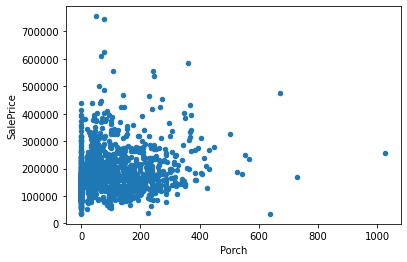

In [91]:
# F63
# creating new feature 
train['Porch'] = train['OpenPorchSF']+train['EnclosedPorch']+train['3SsnPorch']+train['ScreenPorch']
var =  'Porch'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')

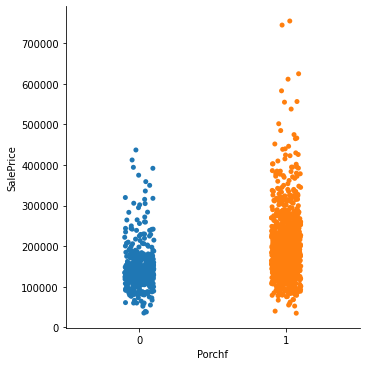

In [92]:
# 3 features: itself, 0/1, and categorical feature
train['Porchf'] = train['Porch'].map(lambda x:0 if x == 0 else 1)
var = 'Porchf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

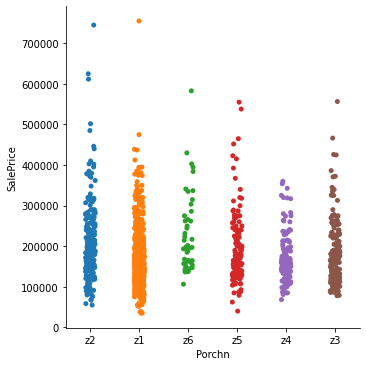

In [93]:
train['Porchn'] = 'z1'
train.loc[(train['Porch'] <= 50), 'Porchn'] = 'z1'
train.loc[(train['Porch'] > 50) & (train['Porch'] <= 100), 'Porchn'] = 'z2'
train.loc[(train['Porch'] > 100) & (train['Porch'] <= 150), 'Porchn'] = 'z3'
train.loc[(train['Porch'] > 150) & (train['Porch'] <= 200), 'Porchn'] = 'z4'
train.loc[(train['Porch'] > 200) & (train['Porch'] <= 300), 'Porchn'] = 'z5'
train.loc[(train['Porch'] > 300) & (train['Porch'] <= 400), 'Porchn'] = 'z6'
train.loc[(train['Porch'] > 400), 'PorchFn'] = 'z7'
var = 'Porchn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

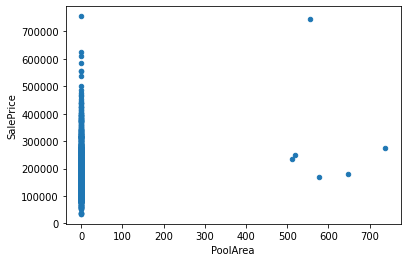

In [94]:
# F64
var = 'PoolArea'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# 0/1

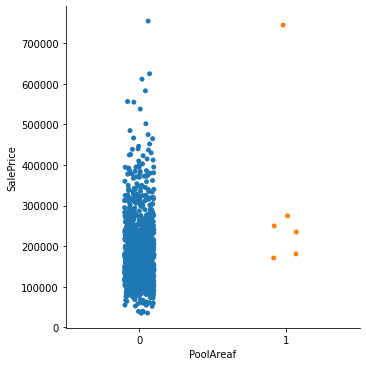

In [95]:
train['PoolAreaf'] = train['PoolArea'].map(lambda x:0 if x == 0 else 1)
var = 'PoolAreaf'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)

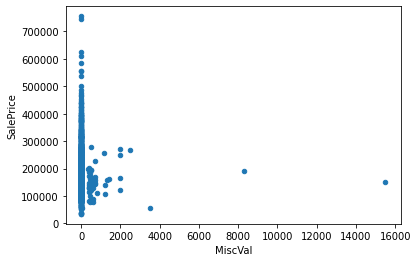

In [96]:
# F65
var = 'MiscVal'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# we remove it since 'MiscFeature' has 1406 zero values.
train = train.drop(columns=['MiscVal'])


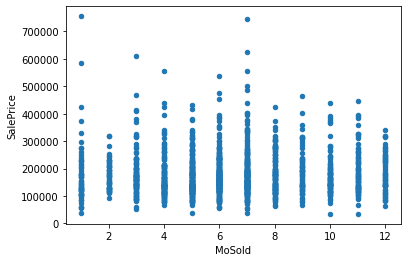

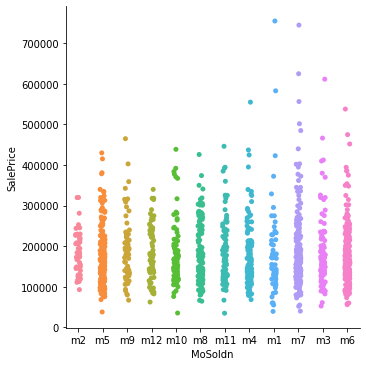

In [97]:
# F66
var = 'MoSold'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# categorical data. month!
scale_mapper = {1:'m1',
                2:'m2',
                3:'m3', 
                4:'m4',
                5: 'm5',
                6: 'm6',
                7:'m7' ,
                8:'m8',
                9: 'm9',
                10:'m10',
                11: 'm11',
                12: 'm12'
                }
train['MoSoldn'] = train['MoSold'].replace(scale_mapper)

var = 'MoSoldn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# we will remove the Msold and keep the dummy

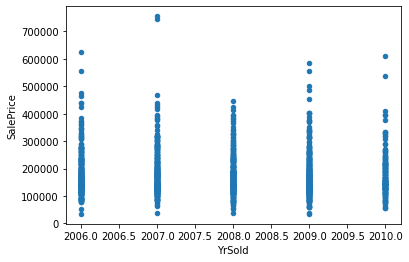

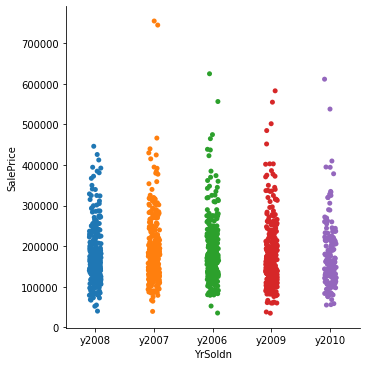

In [98]:
# F66
var = 'YrSold'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
dataPlot.plot.scatter(x= var, y='SalePrice')
# categorical data. 5 years!!
scale_mapper = {2006:'y2006',
                2007:'y2007',
                2008:'y2008', 
                2009:'y2009',
                2010: 'y2010'
                }
train['YrSoldn'] = train['YrSold'].replace(scale_mapper)

var = 'YrSoldn'
dataPlot = pd.concat([train['SalePrice'], train[var]], axis = 1)
fig = sns.catplot(x= var, y='SalePrice', data = dataPlot)
# we will remove the YrSold and keep the dummy

In [99]:
# We looked at all features.
# Now: basement?, 2ndfloor?, Garage? these are new 0/1 features
train['2ndFlr?'] = train['2ndFlrSF'].map(lambda x:0 if x==0 else 1)
train['Bsmt?'] = train['TotalBsmtSF'].map(lambda x:0 if x==0 else 1)
train['Garage?'] = train['GarageArea'].map(lambda x:0 if x==0 else 1)


In [100]:
# quantitative features
quantitative 

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [101]:
# qualitative features
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']